In [ ]:
!pip install everywhereml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 9.1 MB/s eta 0:00:00
  Created wheel for everywhereml: filename=everywhereml-0.2.24-py3-none-any.whl size=79318 sha256=135b8842b0c4a0e73f7884e01c737c6d32a7700c40979755c3e4dbc24e02be4c
  Stored in directory: /root/.cache/pip/wheels/3b/99/c2/328ae739557c5935cdc66dda94b3c6949026acf44f11b68c06
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8894 sha256=0a3fbad30020d1b284d802d616b2af56808b7283bafa21a8a962b4f619af1ade
  Stored in directory: /root/.cache/pip/wheels/26/28/f7/f47d7ecd9ae44c4457e72c8bb617ef18ab332ee2b2a1047e87
  Created wheel for umap-learn

In [ ]:
from everywhereml.data import Dataset
from everywhereml.data.collect import SerialCollector

"""
Create a SerialCollector object.
Each data line is marked by the 'IMU:' string
Collect 30 seconds of data for each gesture
Replace the port with your own!

If a imu.csv file already exists, skip collection
"""

try:
    imu_dataset = Dataset.from_csv(
        'imu.csv',
        name='ContinuousMotion',
        target_name_column='target_name'
    )

except FileNotFoundError:
    imu_collector = SerialCollector(
        port='/dev/cu.usbmodem141401',
        baud=115200,
        start_of_frame='IMU:',
        feature_names=['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    )
    imu_dataset = imu_collector.collect_many_classes(
        dataset_name='ContinuousMotion',
        duration=30
    )

    # save dataset to file for later use
    imu_dataset.df.to_csv('imu.csv', index=False)

In [ ]:
"""
Print summary of dataset
"""
imu_dataset.describe()

,ax,ay,az,gx,gy,gz,target
count,13902.000000,13902.000000,13902.000000,13902.000000,13902.000000,13902.00000,13902.000000
mean,-0.062706,0.126784,0.874660,3.964229,1.939992,-1.01502,1.068264
std,0.186281,0.559018,0.583573,48.614454,63.302283,64.79808,0.819701
min,-1.530000,-1.300000,-1.010000,-850.890000,-302.120000,-247.99000,0.000000
25%,-0.180000,-0.180000,0.400000,-7.510000,-23.130000,-31.56000,0.000000
50%,-0.100000,0.030000,0.930000,0.490000,0.920000,-0.61000,1.000000
75%,0.060000,0.590000,1.160000,14.280000,35.190000,34.55000,2.000000
max,1.330000,4.000000,4.000000,1265.500000,252.930000,328.31000,2.000000


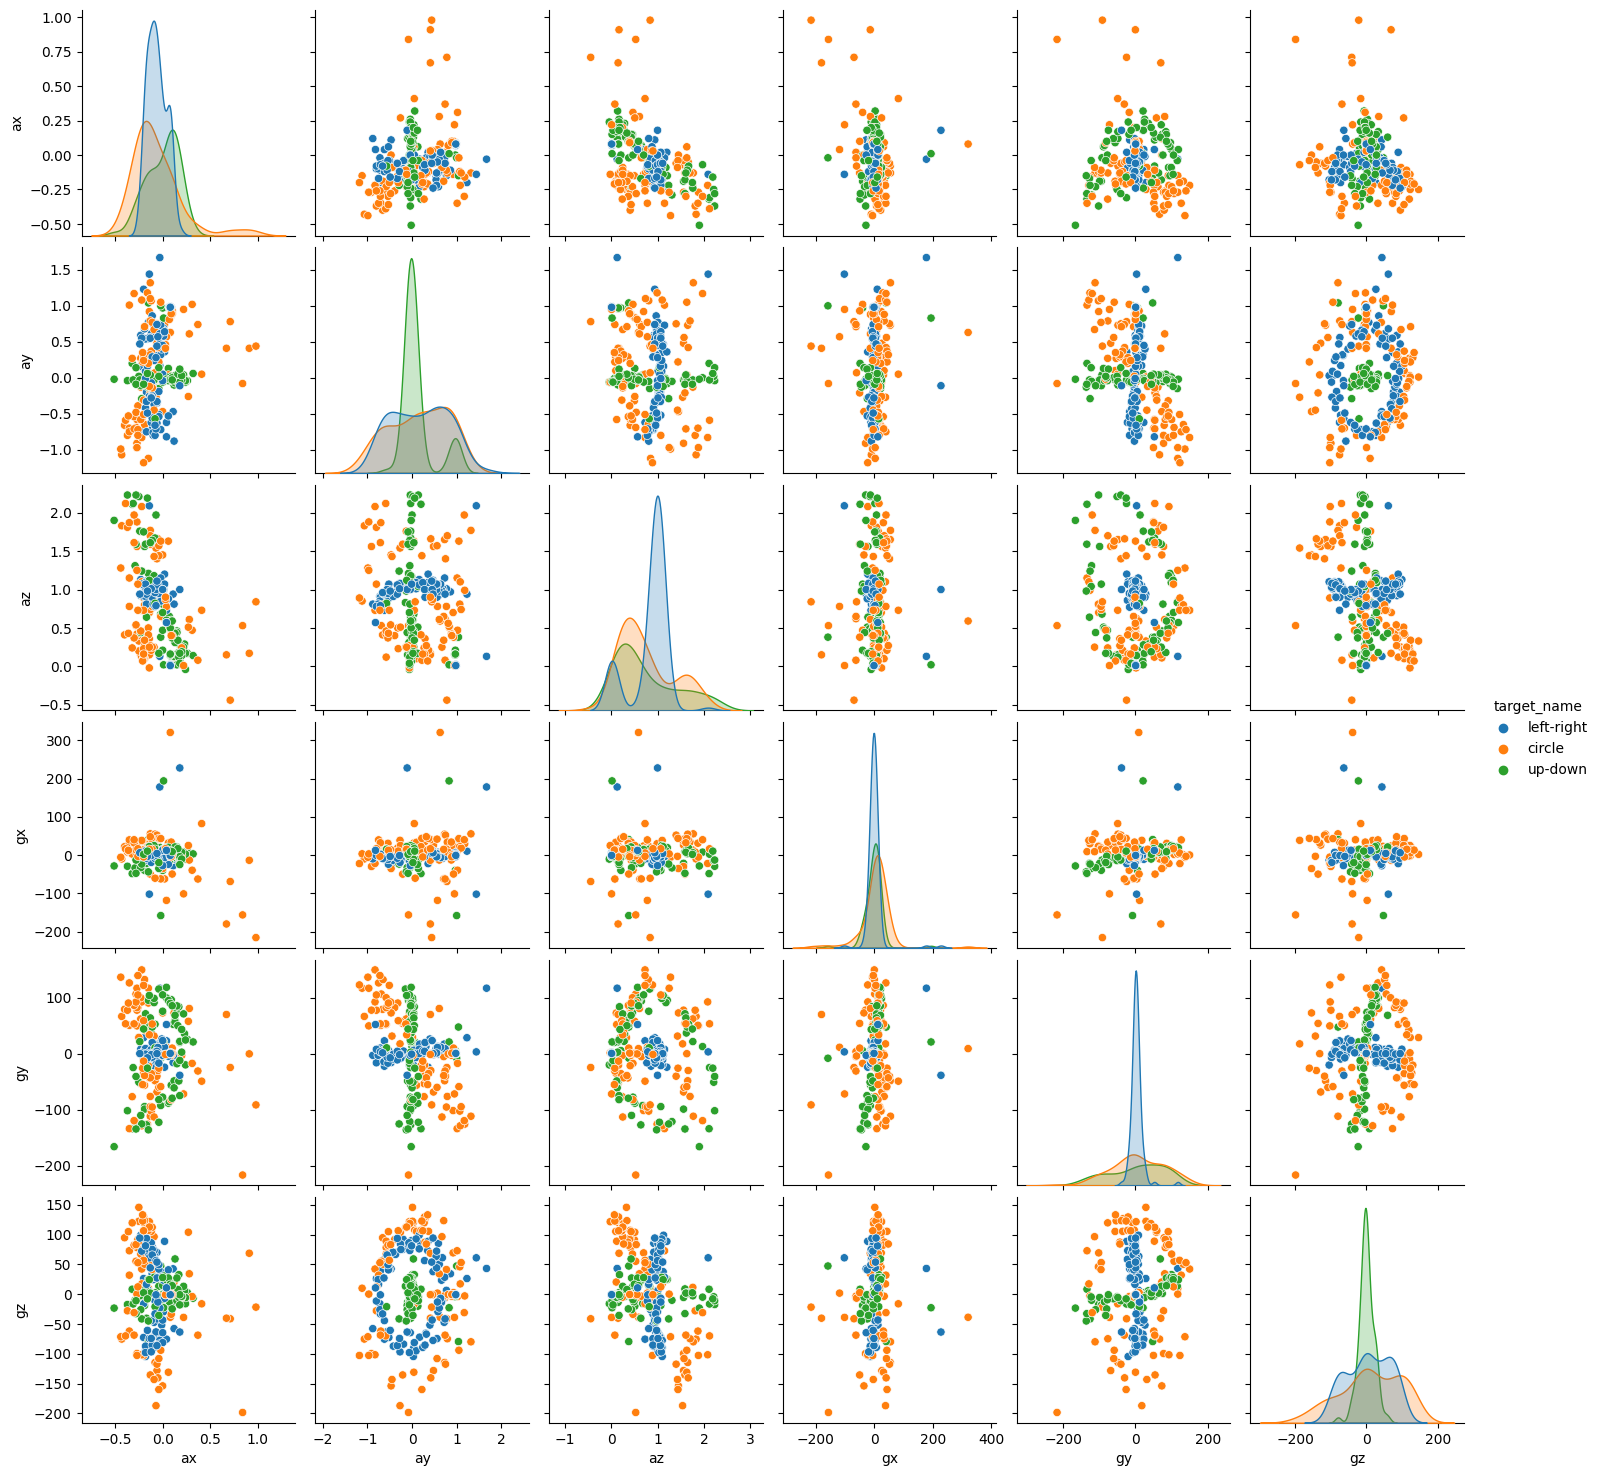

In [ ]:
"""
Plot features pairplot
Since this is a time series dataset, the pairplot won't be very informative
We will come back to the pairplot after feature pre-processing to see great improvements!
"""
imu_dataset.plot.features_pairplot(n=300)

In [ ]:
from everywhereml.preprocessing import Pipeline, MinMaxScaler, Window, SpectralFeatures

# this is the frequency of your sensor
# change according to your hardware
sampling_frequency = 104
mean_gesture_duration_in_millis = 1000
window_length = sampling_frequency * mean_gesture_duration_in_millis // 1000

imu_pipeline = Pipeline(name='ContinousMotionPipeline', steps=[
    MinMaxScaler(),
    # shift can be an integer (number of samples) or a float (percent)
    Window(length=window_length, shift=0.3),
    # order can either be 1 (first-order features) or 2 (add second-order features)
    SpectralFeatures(order=2)
])

In [ ]:
"""
Enumerate features extracted from the SpectralFeatures step
"""
from pprint import pprint

pprint(imu_pipeline['SpectralFeatures'][0].feature_names)

['maximum',
 'minimum',
 'abs_maximum',
 'abs_minimum',
 'mean',
 'abs_energy',
 'mean_abs_change',
 'cid_ce',
 'std',
 'var',
 'count_above_mean',
 'count_below_mean',
 'first_position_of_max',
 'first_position_of_min',
 'max_count',
 'min_count',
 'has_large_std',
 'skew',
 'kurtosis',
 'variation_coefficient']


In [ ]:
"""
Apply feature pre-processing
"""
imu_dataset.apply(imu_pipeline)

In [ ]:
imu_dataset.describe()

,ax_maximum,ax_minimum,ax_abs_maximum,ax_abs_minimum,ax_mean,ax_abs_energy,ax_mean_abs_change,ax_cid_ce,ax_std,ax_var,...,gz_count_below_mean,gz_first_position_of_max,gz_first_position_of_min,gz_max_count,gz_min_count,gz_has_large_std,gz_skew,gz_kurtosis,gz_variation_coefficient,target
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,4.460000e+02,4.460000e+02,...,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,0.586942,0.429874,0.586942,0.429874,0.513022,0.267436,0.007395,0.000443,3.461373e-02,1.695827e-03,...,46.908072,50.943946,52.553812,14.502242,9.029148,0.695067,-0.132979,1.600321,0.216918,1.069507
std,0.091861,0.084704,0.091861,0.084704,0.050534,0.059306,0.006471,0.001529,2.233463e-02,1.869955e-03,...,13.233362,29.509762,28.801693,22.908881,23.152092,0.460896,0.395895,1.692191,0.141367,0.819489
min,0.493007,0.000000,0.493007,0.000000,0.444964,0.198737,0.000000,0.000000,2.220446e-16,4.930381e-32,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-2.757265,0.000000,0.000308,0.000000
25%,0.527972,0.405594,0.527972,0.405594,0.481517,0.232281,0.003267,0.000022,1.621054e-02,2.627815e-04,...,45.000000,28.000000,30.000000,5.000000,1.000000,0.000000,-0.331838,1.418639,0.074097,0.000000
50%,0.562937,0.430070,0.562937,0.430070,0.505026,0.258414,0.006552,0.000096,2.883145e-02,8.312540e-04,...,49.000000,50.000000,51.000000,9.000000,3.000000,1.000000,-0.046329,1.589309,0.234187,1.000000
75%,0.615385,0.461538,0.615385,0.461538,0.530788,0.284050,0.008385,0.000173,5.461791e-02,2.983117e-03,...,54.000000,75.000000,76.000000,13.000000,6.000000,1.000000,0.000000,1.844672,0.356645,2.000000
max,1.000000,0.681818,1.000000,0.681818,0.822250,0.677735,0.053873,0.016381,1.171193e-01,1.371692e-02,...,94.000000,103.000000,103.000000,104.000000,104.000000,1.000000,3.467912,21.711908,0.534780,2.000000


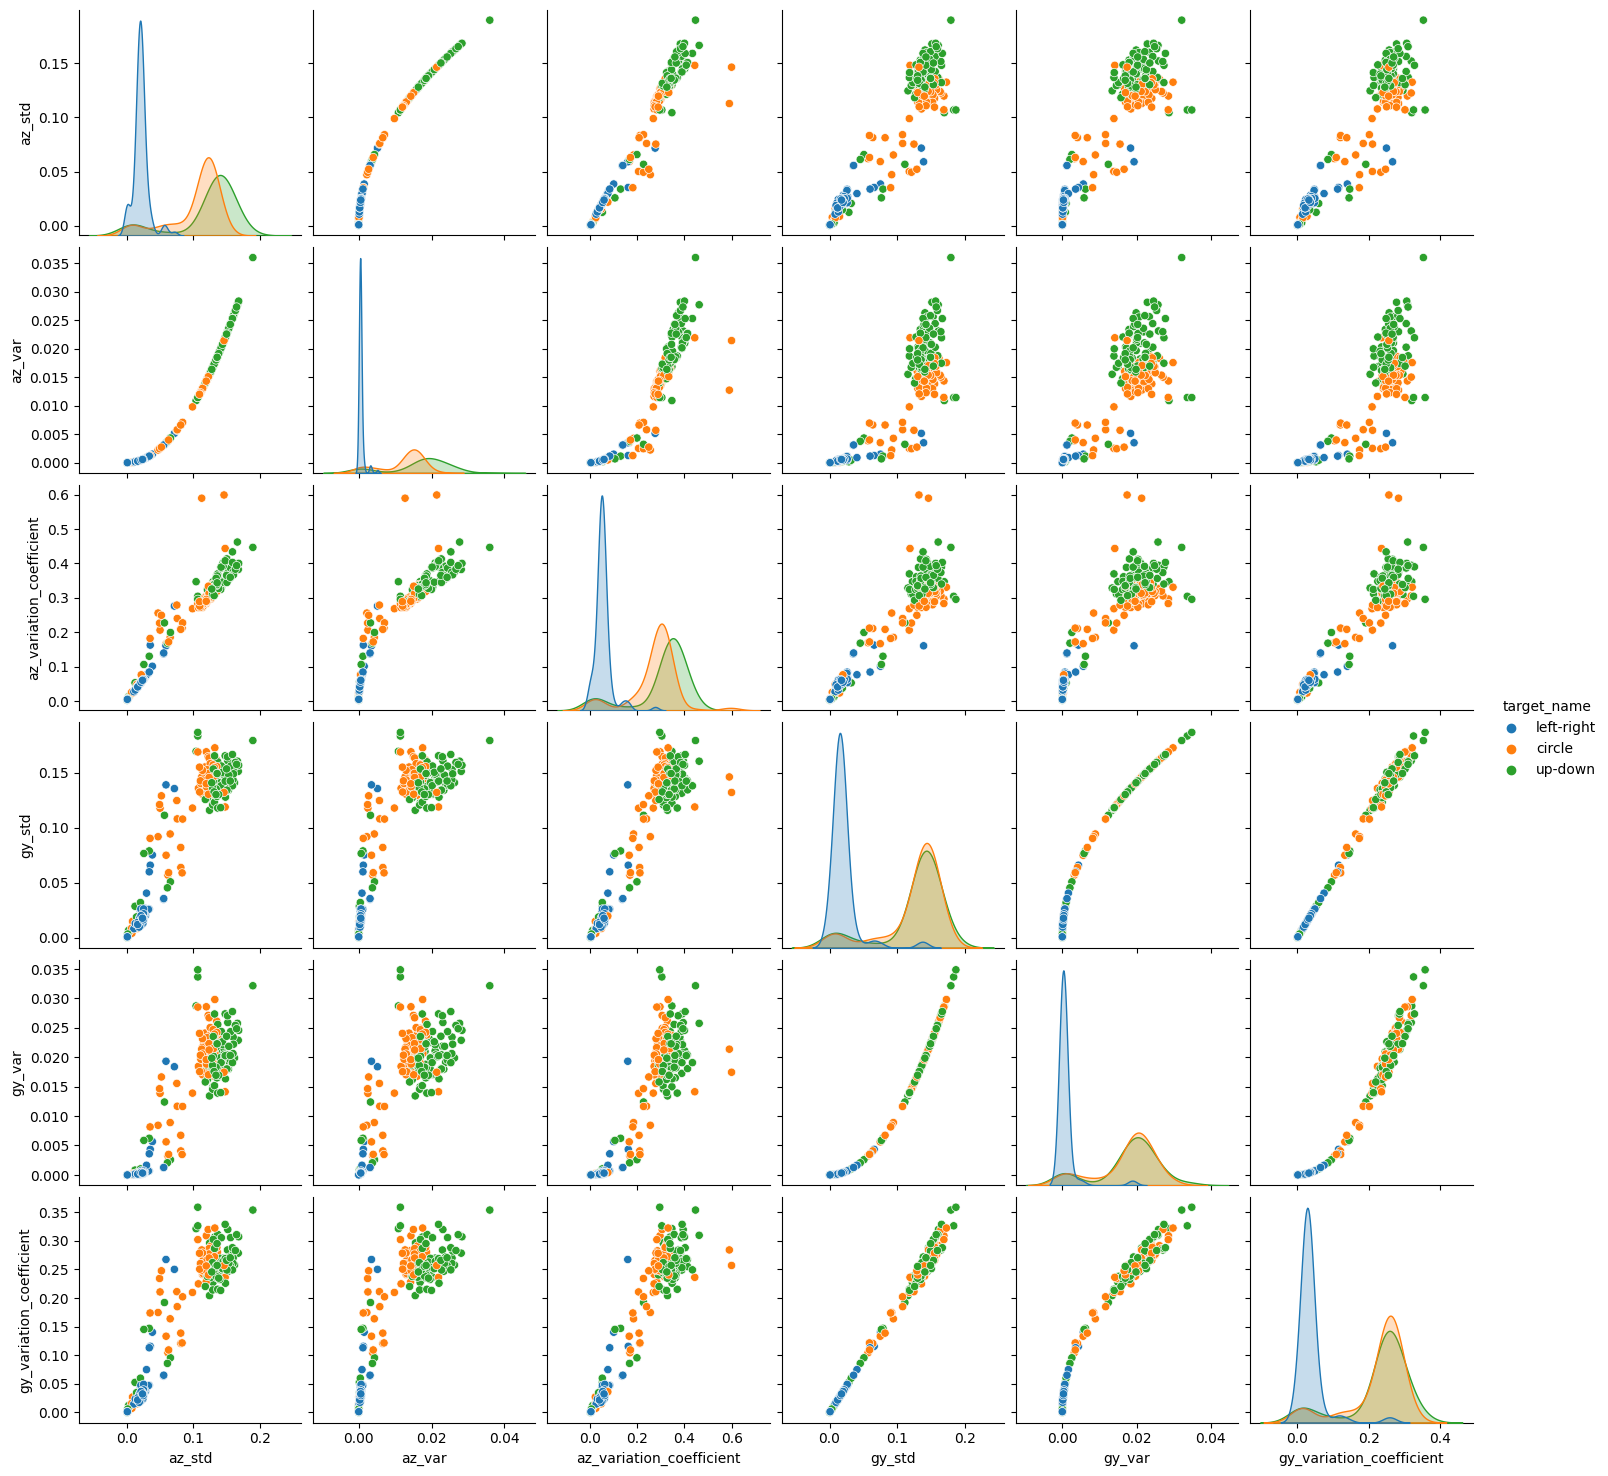

In [ ]:
"""
Plot features pairplot after feature extraction
Now it will start to make sense
Since SpectralFeatures generates 8 or 20 features (depending on the order)
for each axis, we limit the visualization to a more reasonable number
"""
imu_dataset.plot.features_pairplot(n=300, k=6)

In [ ]:
"""
Perform classification with a RandomForest
"""
from everywhereml.sklearn.ensemble import RandomForestClassifier

imu_classifier = RandomForestClassifier(n_estimators=20, max_depth=20)
imu_train, imu_test = imu_dataset.split(test_size=0.3)
imu_classifier.fit(imu_train)

print('Score on test set: %.2f' % imu_classifier.score(imu_test))

Score on test set: 0.96


In [ ]:
"""
Port pipeline to C++
"""
print(imu_pipeline.to_arduino_file(
    'sketches/IMUClassify/Pipeline.h',
    instance_name='pipeline'
))

#ifndef UUID131951022745552
#define UUID131951022745552

#include <cstring>


namespace ContinousMotionPipeline {

    
        #ifndef UUID131950050301680
#define UUID131950050301680

/**
  * MinMaxScaler(low=0, high=1)
 */
class Step0 {
    public:

        /**
         * Transform input vector
         */
        bool transform(float *x) {
            
    for (uint16_t i = 0; i < 6; i++) {
        x[i] = (x[i] - offset[i]) * scale[i] + 0;

        if (x[i] < 0) x[i] = 0;
        else if (x[i] > 1) x[i] = 1;
    }

    return true;


            return true;
        }

    protected:
        
    float offset[6] = {-1.53000000000f, -1.30000000000f, -1.01000000000f, -850.89000000000f, -302.12000000000f, -247.99000000000f};
    float scale[6] = {0.34965034965f, 0.18867924528f, 0.19960079840f, 0.00047250271f, 0.00180163949f, 0.00173520736f};

};



#endif
    
        #ifndef UUID131950050307728
#define UUID131950050307728

/**
  * Window(length=104, shift=31)
 */
class Step1 {
    pub

In [ ]:
"""
Port classifier to C++
"""
print(imu_classifier.to_arduino_file(
    'sketches/IMUClassify/Classifier.h',
    instance_name='forest',
    class_map=imu_dataset.class_map
))

#ifndef UUID131950077114976
#define UUID131950077114976

/**
  * RandomForestClassifier(base_estimator=deprecated, bootstrap=True, ccp_alpha=0.0, class_name=RandomForestClassifier, class_weight=None, criterion=gini, estimator=DecisionTreeClassifier(), estimator_params=('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha'), max_depth=20, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None, num_outputs=3, oob_score=False, package_name=everywhereml.sklearn.ensemble, random_state=None, template_folder=everywhereml/sklearn/ensemble, verbose=0, warm_start=False)
 */
class RandomForestClassifier {
    public:

        /**
         * Predict class from features
         */
        int predict(float *x) {
            int predictedValue =